In [6]:
import hoppings
import hamiltonian
import params
import preimage

reload(hoppings);reload(hamiltonian);reload(params);reload(preimage)

import numpy as np

###
# Parameters for model we will use were found in previous work
###

R = 2
par_final = [2.198000000000001, 1.0400000000000023, 0.7030000000000001, 1.2360000000000029, 1.3000000000000005, 0.13996000000000008, 1.7711999999999957, -0.5539616100000001, 0.11486516999999985, 1.166208670000004, 0.6413160400000001, -0.46604759, 1.8061841200000064]
pOpt_031918 = params.params(R=R,vec = par_final,strobeQ=True)

In [7]:
###
# Run some tests for functions amenable to automated testing
# The largest function, preimage.getPreImage, isn't too amenable to automated testing, as its goal is to produce relatively accurate yet easily computed preimages for 
#  one specific function. The second and third plot showed in the following examine the validity of the algorithm.
###

!nosetests hamiltonian.py --verbose
!nosetests preimage.py --verbose

hamiltonian.test_1 ... ok
hamiltonian.test_2 ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.065s

OK
preimage.test_1 ... ok
preimage.test_2 ... ok
preimage.test_3 ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.059s

OK


In [8]:
###
# Calculate n_x,n_y,n_z on N x N x N grid in Brillouin zone (for use in finding preimages)
# Takes ~16 seconds for N = 100
###

#Choose above-defined model
p = pOpt_031918

#Define grid in Brillouin zone
N = 100 + 1
xs,ys,zs = np.linspace(-np.pi,np.pi,N) + np.pi, np.linspace(-np.pi,np.pi,N) + np.pi,np.linspace(-1.5,1.5,N)
Xs,Ys,Zs = np.meshgrid(xs,ys,zs)

#Get ns on grid
n1s,n2s,n3s,Es = hamiltonian.ns(Xs,Ys,Zs,p)
#Normalize ns (energies Es are by definition their normalization)
n1s/=Es
n2s/=Es
n3s/=Es

<IPython.core.display.Javascript object>


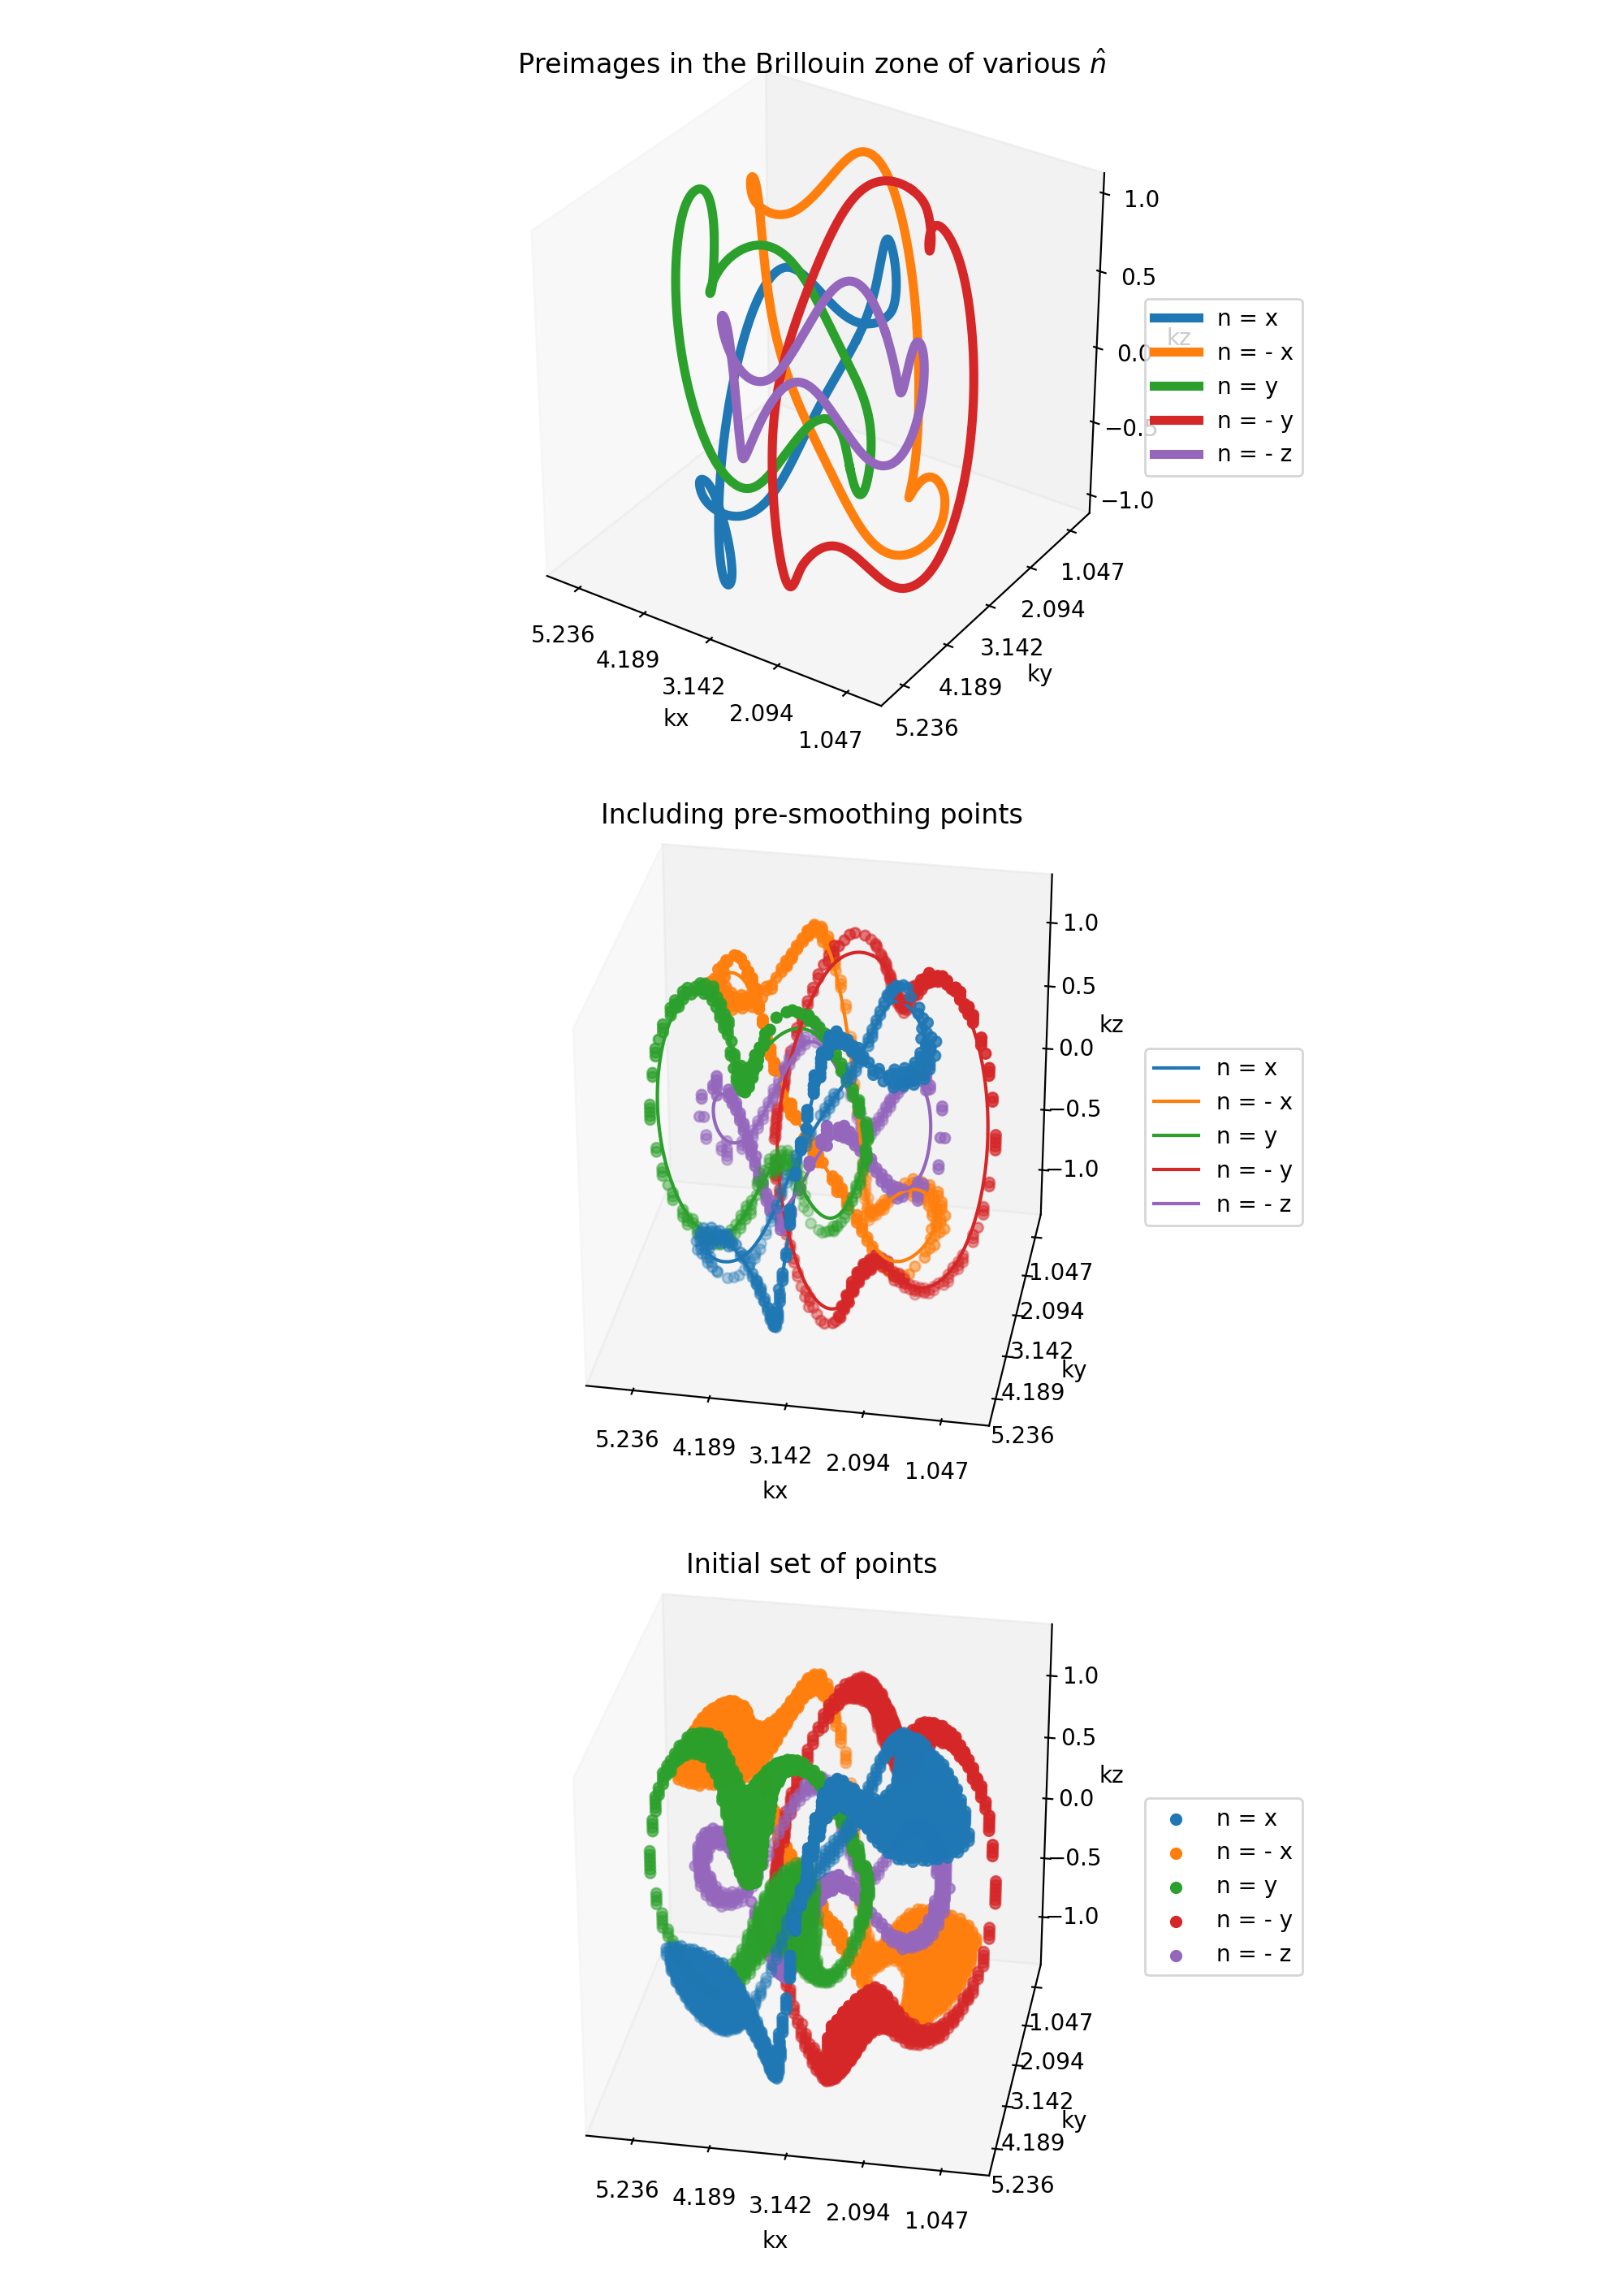

In [9]:
###
# Find preimages & plot using matplotlib
###

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,14)
%matplotlib notebook

ns = np.array([n1s,n2s,n3s])
Rs = np.array([Xs,Ys,Zs])

#All parameters chosen to plot well at N = 100
vs = [[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,-1]] #points on Bloch sphere to find preimages for
v_labels = ["n = x","n = - x","n = y","n = - y","n = - z"] #labels for these points
del_threshs = [2]*4 + [1] #chosen via fiddling and observing what works best
filter_threshs = [[.12,.11,.85]]*4 + [[.07,.1,.89]] #using different parameters for different preimages seems to help
w = .022 #width for gaussian smoothing

#Calculate smoothed preimages
pims = [preimage.getPreImage(ns,Rs,np.array(v),filter_thresh = ft,del_thresh = dt,return_ptsQ=True,width=w) for v,ft,dt in zip(vs,filter_threshs,del_threshs)]

#Plot preimages with matplotlib
view = [30,100]

fig = plt.figure()
ax_final = fig.add_subplot(3,1,1, projection='3d')
ax_filter = fig.add_subplot(3,1,2, projection='3d')
ax_orig = fig.add_subplot(3,1,3, projection='3d')

for pim,v_label in zip(pims,v_labels):
    ax_final.plot(pim[0],pim[1],pim[2],label = v_label,linewidth=4) #Plot each preimage
    ax_filter.plot(pim[0],pim[1],pim[2],label = v_label) #Plot each preimage
    ax_filter.scatter(pim[3],pim[4],pim[5]) #Plot un-smoothed points
    ax_orig.scatter(pim[6],pim[7],pim[8],label = v_label) #Plot un-smoothed points

#Set various axes
for ax in [ax_orig,ax_filter,ax_final]:
    ax.set_xlabel('kx')
    ax.set_ylabel('ky')
    ax.set_zlabel('kz')
    ax.set_xticks(np.linspace(0,2*np.pi,7)[1:-1])
    ax.set_yticks(np.linspace(0,2*np.pi,7)[1:-1])
    ax.set_zticks(np.linspace(-1,1,5))
    ax.grid(b=False)
    ax.legend(loc='center left', bbox_to_anchor=(.95, .5))
    ax.set_aspect('equal')
    ax.view_init(view[0],view[1])
    
ax_final.set_title(r'Preimages in the Brillouin zone of various $\hat{n}$')
ax_filter.set_title('Including pre-smoothing points')
ax_orig.set_title('Initial set of points')

fig.tight_layout()

plt.show()

In [109]:
###
# Save to csv file to be able to plot in Mathematica
###

import csv

myFile = open('preimages.csv', 'w')

with myFile:
    writer = csv.writer(myFile)
    for pim in pims:
        writer.writerows(np.asarray(pim[:3]))

myFile.close()